# Prepare Datasets

In [1]:
import sys

sys.path.append("..")
from src.dataset.dataset import build_FIVES_dataloaders

trainloader, validationloader, testloader = build_FIVES_dataloaders(
    batch_size=8,
    proportion_augmented_data=0.1,
    num_channels=1,
    width=512,
    height=512,
    cropped=False,
    classes=1,
)

Number of samples in the training set: 640, validation set: 60
Number of samples in the test set: 200


# Visualize Dataset

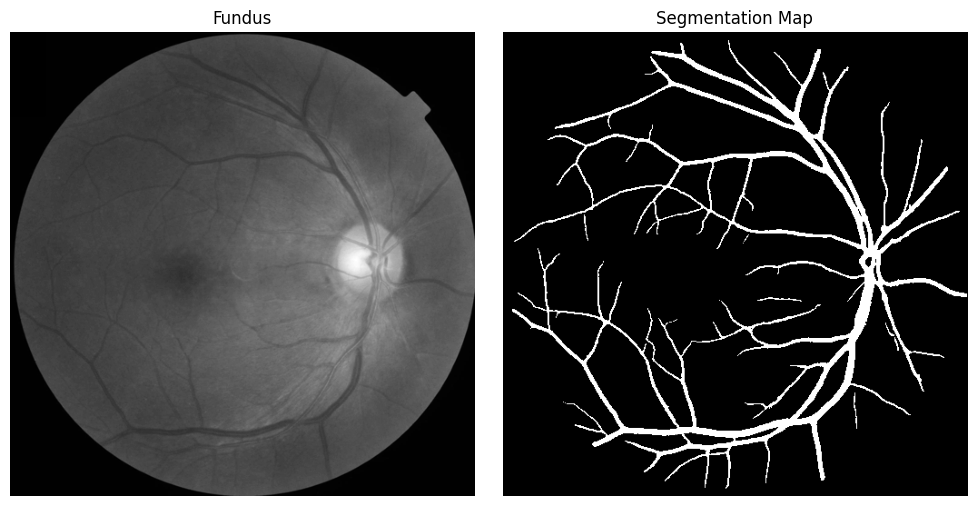

In [2]:
import matplotlib.pyplot as plt

def show_images(images, labels, num_images=5):
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(10, num_images * 5))
    for i in range(num_images):
        img = images[i].numpy().transpose((1, 2, 0))  # Convert from PyTorch tensor format and channel first to channel last
        lbl = labels[i].numpy().squeeze()            # Remove extra dimensions
        if num_images == 1:
            ax_img = axs[0]
            ax_lbl = axs[1]
        else:
            ax_img = axs[i, 0]
            ax_lbl = axs[i, 1]
        
        ax_img.imshow(img, cmap='gray')
        ax_img.set_title('Fundus')
        ax_img.axis('off')
        
        ax_lbl.imshow(lbl, cmap='gray')
        ax_lbl.set_title('Segmentation Map')
        ax_lbl.axis('off')

    plt.tight_layout()
    plt.show()

show_images(*zip(*[trainloader.dataset[i] for i in range(1)]), 1)

# Training

In [ ]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch
from src.util.segmentation_util import (
    model_pipeline,
    build_criterion,
    build_optimizer,
    build_segmentation_model,
)
import matplotlib.pyplot as plt

# Define Hyperparameters
encoder = "timm-regnetx_320"
architecture = "Linknet"
learning_rate = 0.012948375271687074
epochs = 1
loss = "ClDice"
optimizer = "Adam"
in_channels = 1
gamma = 2

config = {
    "model": "{architecture}-{encoder}-{width}x{height}-ClDice".format(
        architecture=architecture, width=512, height=512, encoder=encoder
    ),
    "learning_rate": learning_rate,
    "epochs": epochs,
    "batch_size": trainloader.batch_size,
    "optimizer": optimizer,
    "criterion": loss,
    "encoder": encoder,
    "architecture": architecture,
    "in_channels": in_channels,
    "classes": 1,
    "iter": 10,
    "alpha": 0.5,
    "smooth": 1,
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = build_segmentation_model(
    encoder,
    architecture=config["architecture"],
    device=device,
    in_channels=in_channels,
    classes=config["classes"],
)
optimizer = build_optimizer(
    model, learning_rate=config["learning_rate"], optimizer=config["optimizer"]
)
criterion = build_criterion(
    config["criterion"],
    gamma=gamma,
    iter=config["iter"],
    alpha=config["alpha"],
    smooth=config["smooth"],
)

model, train_losses, val_losses = model_pipeline(
    model,
    trainloader=trainloader,
    validationloader=validationloader,
    testloader=testloader,
    criterion=criterion,
    optimizer=optimizer,
    project="fundus-segmentation",
    model_name=config["model"],
    epochs=config["epochs"],
    device=device,
    config=config,
    with_overlays=True,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Batch 10, Loss: 0.7828


In [5]:
import segmentation_models_pytorch as smp
from src.util.constants import MODELS_DIR
from src.util.segmentation_util import load_model
import torch

model = smp.Linknet('timm-regnetx_320', in_channels=1, classes=1)
model_path = MODELS_DIR / "Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth"
model = load_model(model, model_path, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

# Evaluation

In [ ]:
from src.util.segmentation_util import evaluate_model, predict
import numpy as np
import cv2
import matplotlib.pyplot as plt
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

def show_overlay(model, data, device):
    prediction = predict(model, data[0], device)
    image = data[1].cpu().numpy().squeeze()
    image = np.stack([image, image, image], axis=-1)
    overlay = np.zeros_like(image)
    overlay[prediction.cpu().numpy().squeeze(0) == 1] = [0, 255, 0]
    combined = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(combined, cmap='gray')
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()
        
# show_overlay(model, val_dataset[0], device)
# show_images(*zip(*[train_dataset[i] for i in range(5)]))

# Hyperparameter Tuning

In [ ]:
import wandb
import torch
from src.util.segmentation_util import train_sweep

sweep_config = {
    'name': 'Fundus-Segmentation-Sweep',
    'method': 'bayes',
    'parameters': {
        'encoder': {
            'values': ['resnet152', 'resnext101_32x8d', 'timm-resnest269e', 'timm-regnetx_320', 'timm-regnety_320', 'senet154']
        },
        'learning_rate': {
            "min": 0.00001, 
            "max": 0.1
        },
        'epochs': {
            'value': 10
        },
        'loss': {
            'values': ['Dice', 'BCE']
        },
        'optimizer': {
            'values': ['Adam', 'SGD']
        },
        'batch_size': {
            'value': 8
        },
        'proportion_augmented_data': {
            'values': [0.1, 0.2, 0.3]
        },
        'architecture': {
            'values': ['Unet', 'UnetPlusPlus']
        }
    },
    'metric': {
        'name': 'dice_score',
        'goal': 'maximize'
    }
}
sweep_config['parameters']['device'] = {'value':'cuda:0' if torch.cuda.is_available() else 'cpu'}
sweep_id = wandb.sweep(sweep_config, project='fundus-segmentation')
wandb.agent(sweep_id, function=train_sweep, count=10)